In [18]:
import pandas as pd

In [19]:
data = pd.read_excel("customer_churn_large_dataset.xlsx")

**Data Preprocessing**

In [20]:
data.head()


,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [21]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB
None


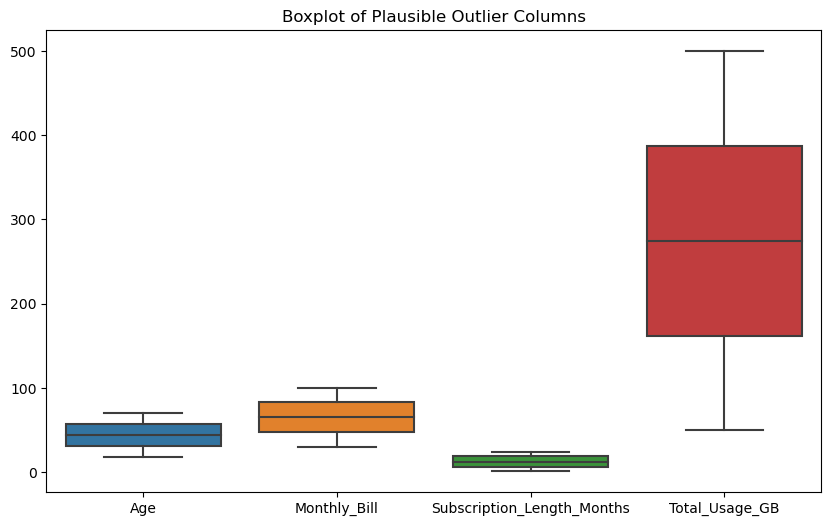

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
outlier_columns = ['Age', 'Monthly_Bill',"Subscription_Length_Months", 'Total_Usage_GB']
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[outlier_columns])
plt.title("Boxplot of Plausible Outlier Columns")
plt.show()

**Feature Engineering**

In [23]:
data["Location"].unique()

array(['Los Angeles', 'New York', 'Miami', 'Chicago', 'Houston'],
      dtype=object)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])  

data = pd.get_dummies(data, columns=['Location'], drop_first=True)

In [25]:
data.drop(['Name','CustomerID'], axis=1, inplace=True)


In [26]:
data.head()

,Age,Gender,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
0,63,1,17,73.36,236,0,0,1,0,0
1,62,0,1,48.76,172,0,0,0,0,1
2,24,0,5,85.47,460,0,0,1,0,0
3,36,0,3,97.94,297,1,0,0,1,0
4,46,0,19,58.14,266,0,0,0,1,0


In [27]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
X = data.drop('Churn', axis=1) 
y = data['Churn']  
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Feature selection
selector = SelectKBest(score_func=f_classif, k="all")
X_selected = selector.fit_transform(X_scaled, y)

print("Feature scores:", selector.scores_)

Feature scores: [2.42999332e-01 4.49834266e-01 5.42063365e-01 4.46465325e-03
 8.07423284e-01 4.52670285e+00 2.31056401e+00 2.74099935e+00
 3.40471440e+00]


This suggests monthly_bill feature might not be a good predictor for churn prediction. However, droping that feature might not be good as monthly bill can be relevant with respect to other features.

**Model Building & Optimization**

In [28]:
# Splitting the selected data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import  GridSearchCV

# Random Forest Classifier with adjusted parameters
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.49995
Precision: 0.49528857479387517
Recall: 0.42384840237879245
F1-score: 0.4567921351366031


In [30]:
from sklearn.linear_model import LogisticRegression
#  Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5036
Precision: 0.49953488372093025
Recall: 0.3788932567281524
F1-score: 0.43092972601169327


**Model Deployment**

In [38]:
from joblib import dump, load
from sklearn.preprocessing import OneHotEncoder
# Saving the trained model to a file using joblib
model_filename = 'churn_prediction_model.joblib'
dump(logreg_model, model_filename)

# Loading the trained model from the file
loaded_model = load(model_filename)
def preprocess_new_customer_data(age, gender, location, subscription_length, monthly_bill):
    # Converting gender to encoded value
    gender_encoded = label_encoder.transform([gender])[0]
    
    # Creating a DataFrame with the corresponding feature columns
    new_customer_data = pd.DataFrame({
        'Age': [age],
        'Gender': [gender_encoded],
        'Subscription_Length_Months': [subscription_length],
        'Monthly_Bill': [monthly_bill],
        'Total_Usage_GB': [150.0],  # Use default value
        'Location_Houston': [0],
        'Location_Los Angeles': [0],
        'Location_Miami': [0],
        'Location_New York': [0]
    })
    
    new_customer_data['Location_' + location] = 1
    new_customer_data_scaled = scaler.transform(new_customer_data)
    
    return new_customer_data_scaled

# Simulating predictions for new customer data
new_customer_age = 30
new_customer_gender = 'Male'
new_customer_location = 'Los Angeles'
new_customer_subscription_length = 12
new_customer_monthly_bill = 80

preprocessed_data = preprocess_new_customer_data(new_customer_age, new_customer_gender, new_customer_location,
                                                new_customer_subscription_length, new_customer_monthly_bill)
prediction = loaded_model.predict(preprocessed_data)
print("Churn Prediction for New Customer:", prediction)

Churn Prediction for New Customer: [0]


That is, a customer with above specification will not churn.